In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

In [2]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.3, random_state = 21)

In [5]:
#Now lets Normalize the data
#First we will calculate the maximum and minimum value from the training set 

min = tf.reduce_min(train_data)
max = tf.reduce_max(train_data)

#Now we will use the formula (data - min)/(max - min)

train_data = (train_data - min)/(max - min)
test_data = (test_data - min)/(max - min)

#I have converted the data into float

train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)

In [6]:
#The labels are either 0 or 1, so I will convert them into boolean(true or false) 

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Now let's separate the data for normal ECG from that of abnormal ones

#Normal ECG data

n_train_data = train_data[train_labels]
n_test_data = test_data[test_labels]

#Abnormal ECG data

an_train_data = train_data[~train_labels]
an_test_data = test_data[~test_labels]

print(n_train_data)

tf.Tensor(
[[0.6903813  0.5696018  0.48864707 ... 0.6000511  0.61441356 0.54897976]
 [0.5478863  0.31753552 0.19417985 ... 0.68793255 0.64354354 0.41783202]
 [0.42973492 0.2905059  0.24810807 ... 0.46692586 0.3873527  0.2770244 ]
 ...
 [0.5027603  0.2960399  0.16074097 ... 0.646512   0.6926702  0.61546504]
 [0.66126615 0.50727856 0.34426397 ... 0.6280548  0.53543323 0.54232544]
 [0.3631103  0.1958676  0.23134111 ... 0.65868723 0.6686304  0.500159  ]], shape=(2059, 140), dtype=float32)


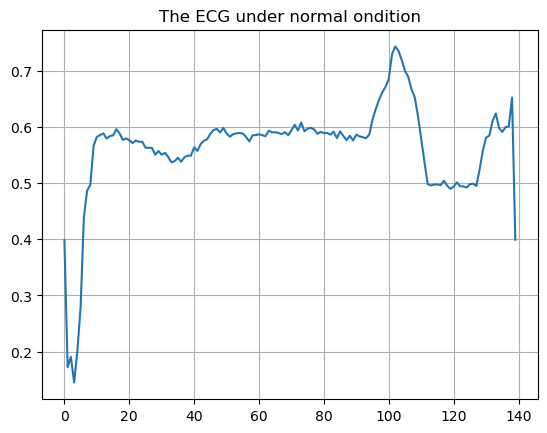

In [7]:
plt.plot(np.arange(140), n_train_data[10])
plt.grid()
plt.title('The ECG under normal ondition')
plt.show()

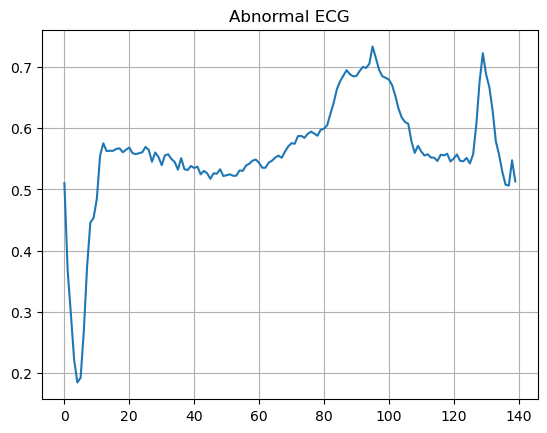

In [8]:
plt.plot(np.arange(140), an_train_data[0])
plt.grid()
plt.title('Abnormal ECG')
plt.show()

In [9]:
#Now let's define the model!

#Here I have used the Model Subclassing API

#The model has 2 parts : 1. Encoder and 2. Decoder
 
class detector(Model):
  def __init__(self):
    super(detector, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [10]:
#Let's compile and train the model!!
autoencoder = detector()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(n_train_data, n_train_data, epochs = 20, batch_size=512, validation_data=(n_test_data, n_test_data))
     

Epoch 1/20
5/5 [==============================] - 2s 43ms/step - loss: 0.0866 - val_loss: 0.0839
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0826 - val_loss: 0.0791
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0777 - val_loss: 0.0738
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0721 - val_loss: 0.0677
Epoch 5/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0658 - val_loss: 0.0611
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0593 - val_loss: 0.0548
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0530 - val_loss: 0.0487
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0471 - val_loss: 0.0435
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0422 - val_loss: 0.0391
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0381 - val_loss: 0.0356
Epoch 11/20
5/5 [=====================

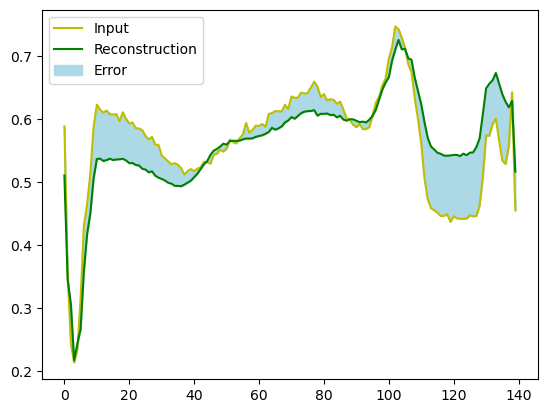

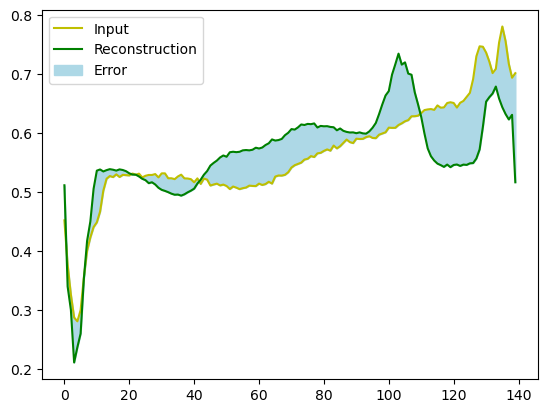

In [11]:
# Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error

def plot(data, n):
  enc_img = autoencoder.encoder(data)
  dec_img = autoencoder.decoder(enc_img)
  plt.plot(data[n], 'y')
  plt.plot(dec_img[n], 'g')
  plt.fill_between(np.arange(140), data[n], dec_img[n], color = 'lightblue')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

plot(n_test_data, 0)
plot(an_test_data, 0)

In [12]:
reconstructed = autoencoder(n_train_data)
train_loss = losses.mae(reconstructed, n_train_data)
t = np.mean(train_loss) + np.std(train_loss)

def prediction(model, data, threshold):
  rec = model(data)
  loss = losses.mae(rec, data)
  return tf.math.less(loss, threshold)
print(t)

0.040761195


In [13]:
pred = prediction(autoencoder, n_test_data, t)
print(pred)

tf.Tensor(
[False  True  True False  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

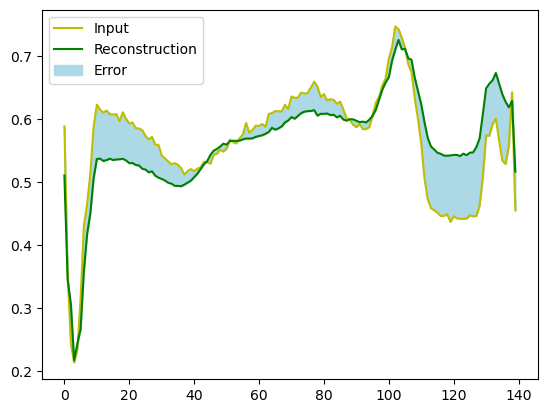

In [14]:
plot(n_test_data, 0)


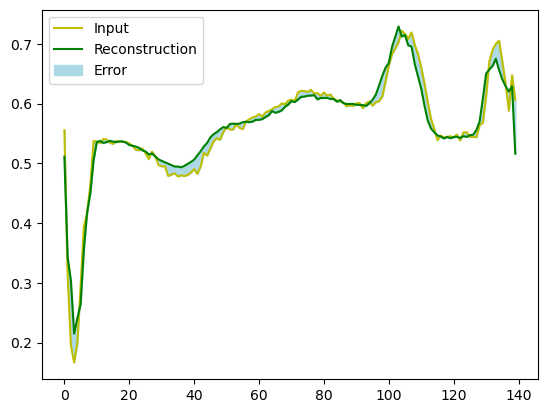

In [15]:
plot(n_test_data, 1)

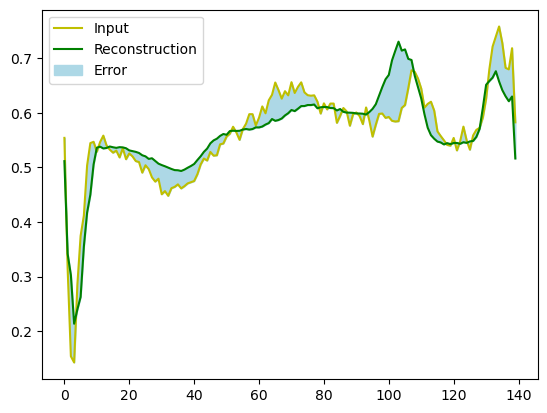

In [16]:
plot(n_test_data, 2)

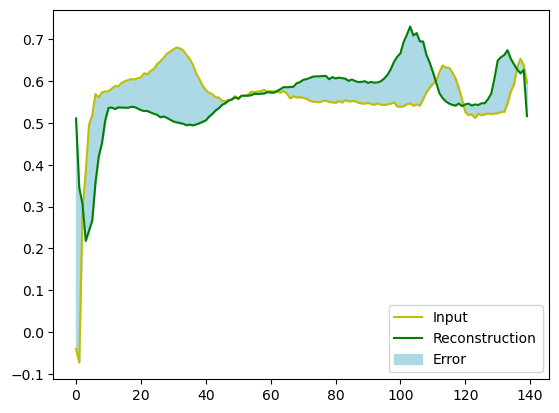

In [17]:
plot(n_test_data, 3)

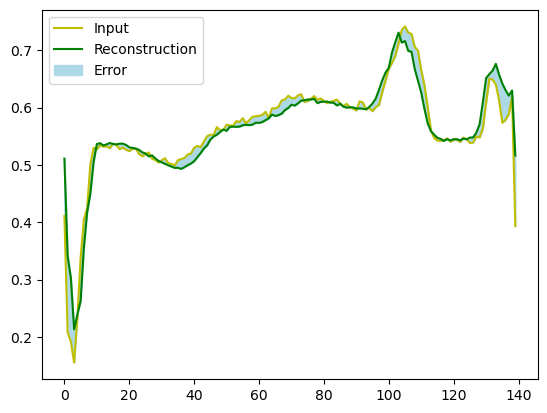

In [18]:
plot(n_test_data, 4)

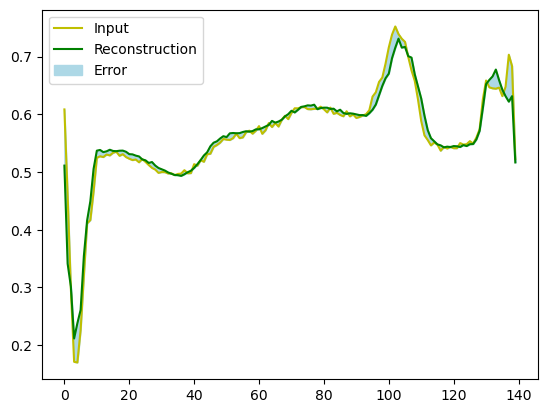

In [19]:
plot(n_test_data, 5)

In [20]:
# Feature Extraction with PCA
pca = PCA(n_components=8)
pca.fit(train_data)
pca_train_data = pca.transform(train_data)
pca_test_data = pca.transform(test_data)

In [21]:
# One-Class SVM Model
svm_model = OneClassSVM(kernel='rbf', nu=0.01)
svm_model.fit(pca_train_data)

OneClassSVM(nu=0.01)

In [22]:
# Variational Autoencoder (VAE) Model
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(140, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(2 * latent_dim)  # Multiply by 2 to get both mean and log_var
        ])
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),  # Input shape matches latent_dim
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')  # Output shape matches input data
        ])
        self.latent_dim = latent_dim

    def sample(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, x):
        z_mean_log_var = self.encoder(x)
        z_mean, z_log_var = tf.split(z_mean_log_var, num_or_size_splits=2, axis=1)
        z = self.sample(z_mean, z_log_var)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_log_var

latent_dim = 16
vae = VAE(latent_dim)


In [23]:
# Model Compilation and Training (for the VAE)
vae.compile(optimizer='adam', loss='mae')
vae.fit(train_data, train_labels, epochs=20, batch_size=32, validation_data=(test_data, test_labels))

Epoch 1/20
110/110 [==============================] - 2s 4ms/step - loss: 1.1074 - output_1_loss: 0.4184 - output_2_loss: 0.3485 - output_3_loss: 0.3405 - val_loss: 0.6483 - val_output_1_loss: 0.3299 - val_output_2_loss: 0.1506 - val_output_3_loss: 0.1679
Epoch 2/20
110/110 [==============================] - 0s 3ms/step - loss: 0.5013 - output_1_loss: 0.2387 - output_2_loss: 0.1307 - output_3_loss: 0.1320 - val_loss: 0.3872 - val_output_1_loss: 0.1525 - val_output_2_loss: 0.1308 - val_output_3_loss: 0.1040
Epoch 3/20
110/110 [==============================] - 0s 3ms/step - loss: 0.3691 - output_1_loss: 0.1373 - output_2_loss: 0.1243 - output_3_loss: 0.1075 - val_loss: 0.3696 - val_output_1_loss: 0.1039 - val_output_2_loss: 0.1297 - val_output_3_loss: 0.1360
Epoch 4/20
110/110 [==============================] - 0s 2ms/step - loss: 0.3294 - output_1_loss: 0.1147 - output_2_loss: 0.1146 - output_3_loss: 0.1002 - val_loss: 0.3358 - val_output_1_loss: 0.1292 - val_output_2_loss: 0.1054 - va

In [24]:
# Function for Plotting ROC Curve
def plot_roc(y_true, y_score, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [25]:
# Ensure that 'train_data' and 'test_data' have the correct shape (matching 'latent_dim')
# You might need to modify 'train_data' and 'test_data' to have the right shape.

# Example: Reshape the input data to match the VAE's input shape
# Assuming 'latent_dim' is set to 16 in your VAE model
# vae = VAE(latent_dim=16)

# Anomaly Detection with the VAE
reconstructed_train = vae(train_data_reshaped)

# Calculate the reconstruction loss
reconstruction_loss = tf.reduce_mean(tf.abs(reconstructed_train - train_data_reshaped), axis=(1, 2))  # Assuming input shape (batch_size, 140)
threshold = tf.reduce_mean(reconstruction_loss) + 1.5 * tf.math.reduce_std(reconstruction_loss)

# Anomaly predictions based on the reconstruction loss
anomaly_predictions = reconstruction_loss > threshold


# # Anomaly Detection with the VAE



# reconstructed_train = vae(train_data)
# train_loss = tf.reduce_mean(tf.abs(reconstructed_train - train_data))
# threshold = train_loss + 1.5 * tf.math.reduce_std(train_loss)

# test_reconstructed = vae(test_data)
# test_loss = tf.reduce_mean(tf.abs(reconstructed_test - test_data))
# anomaly_predictions = test_loss > threshold

NameError: name 'train_data_reshaped' is not defined

In [ ]:
# Evaluate Models
svm_predictions = svm_model.predict(pca_test_data)
svm_predictions = svm_predictions == -1  # Convert to boolean values

In [ ]:
# Calculate Metrics for Autoencoder and SVM
autoencoder_precision = precision_score(test_labels, anomaly_predictions)
autoencoder_recall = recall_score(test_labels, anomaly_predictions)
autoencoder_f1 = f1_score(test_labels, anomaly_predictions)
svm_precision = precision_score(test_labels, svm_predictions)
svm_recall = recall_score(test_labels, svm_predictions)
svm_f1 = f1_score(test_labels, svm_predictions)

In [ ]:
print(f'Autoencoder Precision: {autoencoder_precision:.2f}')
print(f'Autoencoder Recall: {autoencoder_recall:.2f}')
print(f'Autoencoder F1 Score: {autoencoder_f1:.2f}')
print(f'SVM Precision: {svm_precision:.2f}')
print(f'SVM Recall: {svm_recall:.2f}')
print(f'SVM F1 Score: {svm_f1:.2f}')

In [ ]:
# Plot ROC Curves
plot_roc(test_labels, test_loss, 'Autoencoder')
plot_roc(test_labels, svm_predictions, 'SVM')

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()